### Calculate and plot the seasonal climatology of Southern Ocean chlorophyll-a from GlobColour

In [84]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import utils.geo as geo

In [85]:
import matplotlib as mpl
mpl.rcParams['font.size']=20
mpl.rcParams['font.family']='serif'
mpl.rcParams['font.serif']='Times'
mpl.rcParams['xtick.labelsize']=14
mpl.rcParams['ytick.labelsize']=14
mpl.rcParams['legend.fontsize']=14

Note that this notebook makes use of my `utils` package, available [here](https://github.com/gmacgilchrist/utils)

## Working from processed globcolour data (daily, interpolated)
Processed in `calc_spatialmean_globcolour_daily.ipynb` and data saved here: `../../data/globcolour_cmems_daily_CHL_wmean-latlon_byyear-JULtoJUN.nc`

In [89]:
smooth = True
basins=True

In [90]:
ds = xr.open_dataset('../../data/globcolour_cmems_daily_CHL_wmean-latlon_byyear-JULtoJUN.nc')
smoothval = 14
if smooth:
    ds = ds.rolling(day=smoothval,center=True).mean()

In [91]:
if basins:
    bs = xr.Dataset()
    bs['pacific'] = xr.open_dataarray('../../data/globcolour_cmems_daily_CHL_wmean-latlon_byyear-JULtoJUN_pacific.nc')
    bs['indian'] = xr.open_dataarray('../../data/globcolour_cmems_daily_CHL_wmean-latlon_byyear-JULtoJUN_indian.nc')
    bs['atlantic'] = xr.open_dataarray('../../data/globcolour_cmems_daily_CHL_wmean-latlon_byyear-JULtoJUN_atlantic.nc')
    smooth = True
    smoothval = 14
    if smooth:
        bs = bs.rolling(day=smoothval,center=True).mean()
    anoms = bs.sel(year=2021)-bs.sel(year=slice(1998,2020)).mean('year')

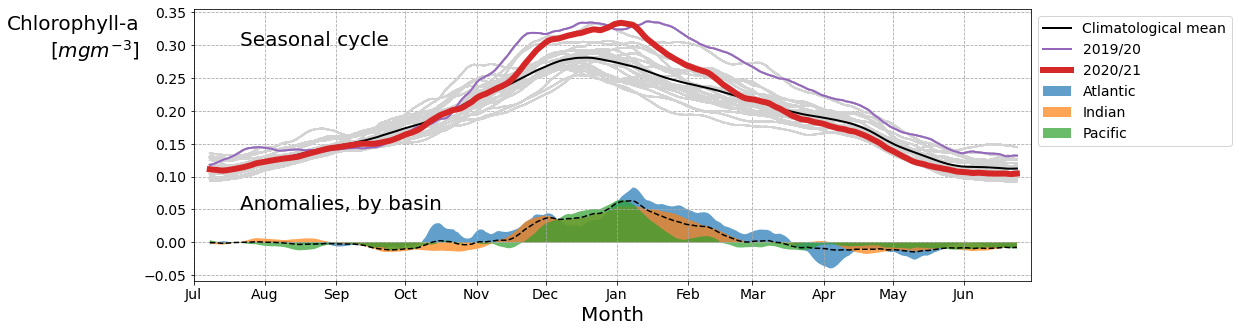

In [92]:
fig,ax = plt.subplots(figsize=(15,5))
# All years
for year in ds['year'][:-1]:
    ax.plot(ds['day'],ds['CHL'],color='lightgray')
# Climatology
ds_clim = ds.sel(year=slice(1998,2020)).mean('year')
ax.plot(ds_clim['day'],ds_clim['CHL'],color='black',linewidth=2,label='Climatological mean')
# 2020
ax.plot(ds['day'],ds['CHL'].sel(year=2020),color='tab:purple',linewidth=2,label='2019/20')
# 2021
ax.plot(ds['day'],ds['CHL'].sel(year=2021),color='tab:red',linewidth=6,label='2020/21')

monthname = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
monthlength = np.array([31,31,30,31,30,31,31,28,31,30,31,30])
monthday = np.append(np.array([0]),np.cumsum(monthlength))
ax.set_xticks(monthday[:-1])
ax.set_xticklabels(monthname)
ax.set_xlim(0,364)
ax.set_xlabel('Month')
ax.set_ylabel('Chlorophyll-a\n[$mgm^{-3}$]',rotation=0,ha='right',y=0.8)
ax.grid(linestyle='--',color='darkgray')

ax.text(20,0.3,'Seasonal cycle')

if basins:
    anomtot = ds['CHL'].sel(year=2021) - ds_clim['CHL']
    ax.plot(anomtot['day'],anomtot,color='k',linestyle='--')
    # Basin anomalies
    plot_kwargs = {'alpha':0.7}
    b1 = ax.fill_between(anoms['day'],anoms['atlantic'],label='Atlantic',**plot_kwargs)
    b2 = ax.fill_between(anoms['day'],anoms['indian'],label='Indian',**plot_kwargs)
    b3 = ax.fill_between(anoms['day'],anoms['pacific'],label='Pacific',**plot_kwargs)

    ax.text(20,0.05,'Anomalies, by basin')

ax.legend(bbox_to_anchor=(1,1))

savename = 'seasonal-climatology_globcolour_cmems_daily_CHL'
if smooth:
    savename = savename+'_smooth-'+str(smoothval)
if basins:
    savename = savename+'_basins'
fig.savefig('../../figures/'+savename+'.png',dpi=300,transparent=True)

## Working from raw globcolour (8-day) data

### Load data.

In [2]:
def preprocess(ds):
    time = pd.to_datetime(ds.attrs['start_time'])
    return ds.expand_dims({'time':[time]})

rootdir = '/local/data/globcolour/merged/8-day/'
mode = 'AV'
var = 'CHL1'

if mode =='AV':
    # Requires that we separately load AV and AVW data
    print('Loading.')
    # Straight averages
    paths = glob.glob(rootdir+'*/*/*/*_'+mode+'-*'+var+'_8D_00.nc')
    ds = xr.open_mfdataset(paths,preprocess=preprocess,use_cftime=False)
    ds = ds.sel({'lat':slice(-40,-65)})
    ds['time'] = pd.to_datetime(ds['time'].values)

    # Weighted averages
    pathsW = glob.glob(rootdir+'*/*/*/*_'+mode+'W-*'+var+'_8D_00.nc')
    dsW = xr.open_mfdataset(pathsW,preprocess=preprocess,use_cftime=False).drop([var+'_error'])
    dsW = dsW.sel({'lat':slice(-40,-65)})#.assign_coords({'lat':ds['lat'],'lon':ds['lon']})
    dsW['time'] = pd.to_datetime(dsW['time'].values)

    # Merge datasets (takes some time) and reset chunks
    print('Merging.')
    ds = xr.merge([ds,dsW]).chunk({'time':1})
    
elif mode == 'GSM':
    print('Loading.')
    print('Merging.')
    paths = glob.glob(rootdir+'*/*/*/*'+mode+'*'+var+'*.nc')
    ds = xr.open_mfdataset(paths,preprocess=preprocess,use_cftime=False)
    ds = ds.sel({'lat':slice(-30,-65)})
    ds['time'] = pd.to_datetime(ds['time'].values)

Loading.
Merging.


In [3]:
# Get area
ds,xgrid = geo.get_xgcm_horizontal(ds,periodic='X')
ds['area'] = ds['dxC']*ds['dyC']

### Average data.

In [44]:
# Extract spatial average for each year
# Interpolate to each of 365 days
years = np.arange(1997,2022)
days = np.arange(1,367)
ds_year = xr.DataArray(dims=['day','year'],coords={'year':years,'day':days})
# fig,ax=plt.subplots()
for i,year in enumerate(years):
    print(year)
    # Need to set nans to zero otherwise it ignores them in the average!
    xs = (ds.sel({'time':slice(str(year)+'-01-01',str(year)+'-12-31')}))
    x = xs['CHL1_mean'].fillna(0).where(xs['CHL1_flags']!=9,np.nan).weighted(ds['area'].fillna(0)).mean(['lat','lon'])
#     if year==1997:
#         x = x.load()
#         x[0]=np.nan
    fill_value=np.nan
#     ax.plot(x['time.dayofyear'],x)
    x_allyear = x.assign_coords({'time':x['time.dayofyear']}).interp({'time':days},kwargs={'fill_value': fill_value})
    ds_year.loc[{'year':year}]=x_allyear.values

1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


### Plot data.

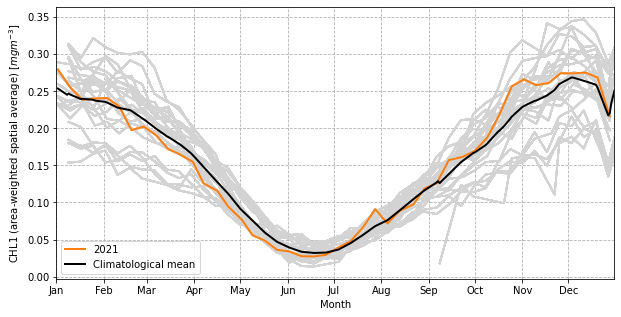

In [45]:
fig,ax = plt.subplots(figsize=(10,5))
# All years
for year in years[:-1]:
    ax.plot(ds_year['day'],ds_year,color='lightgray')
# 2021
ax.plot(ds_year['day'],ds_year.isel(year=-1),color='tab:orange',linewidth=2,label='2021')
# Climatology
ds_clim = ds_year.mean('year')
ax.plot(ds_year['day'],ds_clim,color='black',linewidth=2,label='Climatological mean')

monthname = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthlength = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
monthday = np.append(np.array([0]),np.cumsum(monthlength))
ax.set_xticks(monthday[:-1])
ax.set_xticklabels(monthname)
ax.set_xlim(0,364)
ax.set_xlabel('Month')
ax.set_ylabel(var+' (area-weighted spatial average) [$mgm^{-3}$]')
ax.grid(linestyle='--')

ax.legend()
fig.savefig('../../figures/seasonal-climatology_globcolour_'+var+'_'+mode+'.png',dpi=300,transparent=True)

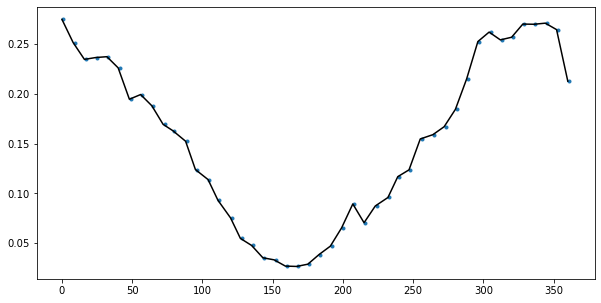

In [14]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(x['time.dayofyear'],x,marker='.',linestyle='none')
ax.plot(x_allyear,color='k')

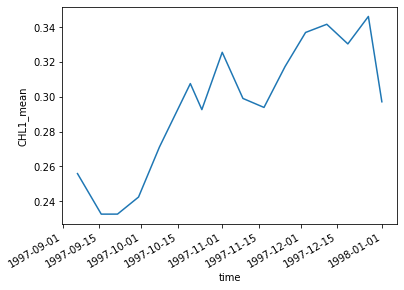

In [26]:
year = 1997
ds['CHL1_mean'].where(ds['CHL1_flags']==8,np.nan).sel({'time':slice(str(year)+'-01-01',str(year)+'-12-31')}).weighted(ds['area'].fillna(0)).mean(['lat','lon']).plot()

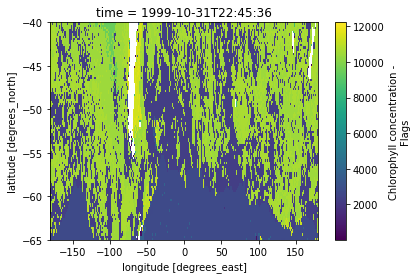

In [43]:
(ds['CHL1_flags'].where((ds['CHL1_flags']!=9) & (ds['CHL1_flags']!=1),np.nan)).isel(time=100).plot()

In [42]:
np.unique(ds['CHL1_flags'].isel(time=100))

array([1.0000e+00, 2.0000e+00, 9.0000e+00, 1.0000e+01, 6.5000e+01,
       6.6000e+01, 1.2900e+02, 1.3000e+02, 5.1300e+02, 5.2100e+02,
       5.7700e+02, 6.4100e+02, 1.2170e+03, 1.2180e+03, 1.7290e+03,
       2.0490e+03, 2.0500e+03, 2.1130e+03, 2.1140e+03, 2.1770e+03,
       2.1780e+03, 2.2410e+03, 2.2420e+03, 2.5610e+03, 2.6250e+03,
       2.6890e+03, 2.6900e+03, 2.7530e+03, 2.7540e+03, 3.0730e+03,
       3.0740e+03, 3.1370e+03, 3.1380e+03, 3.2010e+03, 3.2650e+03,
       3.2660e+03, 3.5850e+03, 3.6490e+03, 3.7130e+03, 3.7770e+03,
       8.1920e+03, 8.2000e+03, 8.2560e+03, 8.4480e+03, 8.4560e+03,
       8.5120e+03, 8.5760e+03, 8.9600e+03, 9.0880e+03, 9.4080e+03,
       9.6640e+03, 1.0240e+04, 1.0304e+04, 1.0368e+04, 1.0432e+04,
       1.0496e+04, 1.0560e+04, 1.0624e+04, 1.0688e+04, 1.0752e+04,
       1.0816e+04, 1.0880e+04, 1.0944e+04, 1.1008e+04, 1.1072e+04,
       1.1136e+04, 1.1200e+04, 1.1264e+04, 1.1328e+04, 1.1392e+04,
       1.1456e+04, 1.1520e+04, 1.1584e+04, 1.1648e+04, 1.1712e